# Neural ODE Imputation

*Author: Areeb Gani (areeb.gani@yale.edu)*

For this project, I use a NeuralODE to impute patient-level clinical trial data in the latent space. I will be using the TOPCAT Study, which assesses the effect of a drug called spironolactone on patients with heart failure with preserved ejection fraction (HFpEF).

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import phate
import scprep

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm

import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.nn import Augmenter
from torchdyn.models import CNF

import pytorch_lightning as pl

C:\Users\gania\AppData\Local\Temp\ipykernel_4292\2769589142.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 2. Loading the Data

Here I load the data from one of the database files, subsetting my desired measurements.

In [272]:
t016 = pd.read_sas('datasets/t016.sas7bdat')
measurements16 = ["NA_mmolL", "K_mmolL", "CL_mmolL", "CO2_mmolL", "BUN_mgdL", "CR_mgdL"]

df_16 = t016[(t016[measurements16] > 0).all(axis=1)].dropna().drop_duplicates(subset=['ID', 'VISIT'])

df_16 = df_16[['ID', 'VISIT'] + measurements16]

In [30]:
#t013 = pd.read_sas('datasets/t013.sas7bdat')
#measurements13 = ["waistc", "weight", "HR", "SBP", "DBP"]

#df_13 = t013[(t013[measurements13] > 0).all(axis=1)].dropna().drop_duplicates(subset=['ID', 'VISIT'])

#df_13 = df_13[['ID', 'VISIT'] + measurements13]

In [273]:
#df = df_13.merge(df_16, on=['ID', 'VISIT'], how='inner')
df = df_16

Convert the bytecode "VISIT" column to numbers.

In [274]:
def convert_to_weeks(time):
    time = time.decode()
    if time == 'BASE':
        return 0
    
    unit, duration = time[:2], time[2:]

    if unit == 'WK':
        return int(duration)
    else:
        return int(duration) * 4

df['VISIT_CONT'] = df['VISIT'].apply(convert_to_weeks)

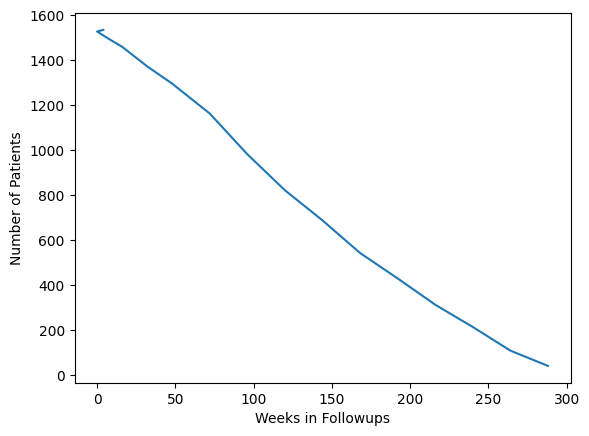

In [319]:
df['VISIT_CONT'].value_counts().plot()
plt.ylabel('Number of Patients')
plt.xlabel('Weeks in Followups')
plt.savefig('dropoff_followups.png')

## 3. Creating the Embedding

Here I scale the continuous values.

In [275]:
ids, visit, visit_cont = df['ID'], df['VISIT'], df['VISIT_CONT']

measurements = measurements16
scaler = StandardScaler()
df[measurements] = scaler.fit_transform(df[measurements])

In [34]:
#phate_operator = phate.PHATE(n_jobs=-2)
#Y_embedding = phate_operator.fit_transform(df[measurements])

Calculating PHATE...
  Running PHATE on 11095 observations and 11 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.73 seconds.
    Calculating affinities...
    Calculated affinities in 0.10 seconds.
  Calculated graph and diffusion operator in 1.84 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 9.55 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.78 seconds.
  Calculated landmark operator in 15.48 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 41.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.25 seconds.
Calculated PHATE in 67.07 seconds.


Now I embed the data, and create a new dataframe accordingly.

In [276]:
pca = PCA(n_components=2)
Y_embedding = pca.fit_transform(df[measurements])

In [94]:
new_df = pd.DataFrame(np.transpose([ids, visit, visit_cont, Y_embedding[:, 0], Y_embedding[:, 1]]),
                      columns=['ID', 'VISIT', 'VISIT_CONT', 'PC1', 'PC2'])

Visualize the embedding until time step 96 (weeks).

In [390]:
base_point, end_point = 0, 96
base_pc1, base_pc2, end_pc1, end_pc2 = [], [], [], []

i = 0

# Compute the PCs for valid pairs
for idx in new_df['ID'].unique():
    i += 1
    if i % 400 == 0:
        print(i)
    relevant = new_df.loc[new_df['ID'] == idx]
    if (base_point in relevant['VISIT_CONT'].values) and (end_point in relevant['VISIT_CONT'].values):
        base = relevant.loc[relevant['VISIT_CONT'] == base_point].iloc[0]
        end = relevant.loc[relevant['VISIT_CONT'] == end_point].iloc[0]
        base_pc1.append(base['PC1'])
        base_pc2.append(base['PC2'])
        end_pc1.append(end['PC1'])
        end_pc2.append(end['PC2'])

400
800


1200
1600


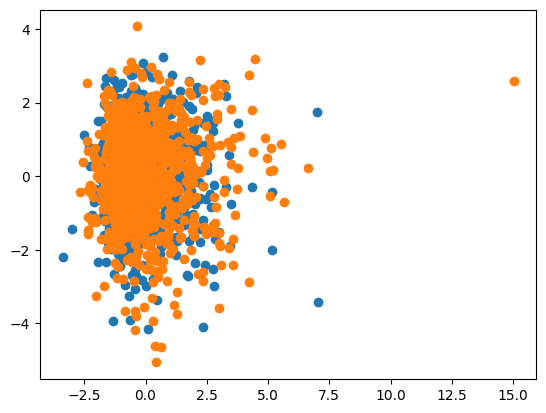

In [284]:
plt.scatter(base_pc1, base_pc2)
plt.scatter(end_pc1, end_pc2)

plt.savefig('latent_space_visualization.png')

Create function that will make it easy to query matching data for training.

In [109]:
df_times = dict()

for i in new_df['VISIT_CONT'].unique():
    df_times[i] = new_df.loc[new_df['VISIT_CONT'] == i]

In [113]:
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None 

# Function to query data at each time end
def input_vars(end, base=0):
    df_base = df_times[base].copy()
    df_end = df_times[end].copy()

    df_base = df_base.loc[df_base['ID'].isin(df_end['ID'])]
    df_end = df_end.loc[df_end['ID'].isin(df_base['ID'])]

    assert(np.array_equal(df_base['ID'].values, df_end['ID'].values))

    X = df_base[["PC1", "PC2"]]
    Y = df_end[["PC1", "PC2"]]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    X_train['PC1'] = pd.to_numeric(X_train['PC1'])
    X_train['PC2'] = pd.to_numeric(X_train['PC2'])

    Y_train['PC1'] = pd.to_numeric(Y_train['PC1'])
    Y_train['PC2'] = pd.to_numeric(Y_train['PC2'])

    X_test['PC1'] = pd.to_numeric(X_test['PC1'])
    X_test['PC2'] = pd.to_numeric(X_test['PC2'])

    Y_test['PC1'] = pd.to_numeric(Y_test['PC1'])
    Y_test['PC2'] = pd.to_numeric(Y_test['PC2'])

    t_span = torch.linspace(base, end, steps=end)
    
    return X_train, Y_train, X_test, Y_test, t_span


## 4. Neural ODE

Here is the crux of the deep learning — we create the Neural ODE with torchdyn and the Pytorch-Lightning module.

In [116]:
class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1]
        loss = nn.MSELoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [117]:
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2),
    )

model = NeuralODE(f, sensitivity='adjoint', solver='tsit5', interpolator=None, atol=1e-3, rtol=1e-3)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Now, we can train the data as we query different time steps.

In [125]:
data_dict = dict()

# Run training at each time interval
for i in sorted(df_times.keys())[1:]: 
    X_train, Y_train, X_test, Y_test, t_span = input_vars(i)
    data_dict[i] = [X_train, Y_train, X_test, Y_test, t_span]

    X_train_torch = torch.Tensor(X_train.to_numpy())
    Y_train_torch = torch.Tensor(Y_train.to_numpy())

    train = data.TensorDataset(X_train_torch, Y_train_torch)
    trainloader = data.DataLoader(train, batch_size=250, shuffle=True)

    learn = Learner(t_span, model)
    max_time = dict(minutes=15)
    trainer = pl.Trainer(max_epochs=250, max_time=max_time)
    trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every

Training: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:15:00. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (6) is smaller than the logging int

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.6 K 
------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\gania\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## 5. Evaluation

In [267]:
device = torch.device("cpu")

end = 96

X_test, Y_test, t_span = data_dict[end][2:]

X_test_torch = torch.Tensor(X_test.to_numpy()).to(device)

Test trajectories, and make visualizations.

In [268]:
t_eval, trajectory = model(X_test_torch, t_span)
trajectory = trajectory.detach().cpu()
trajectory.shape

torch.Size([48, 1205, 2])

Here is a sample where the trajectory was pretty good!

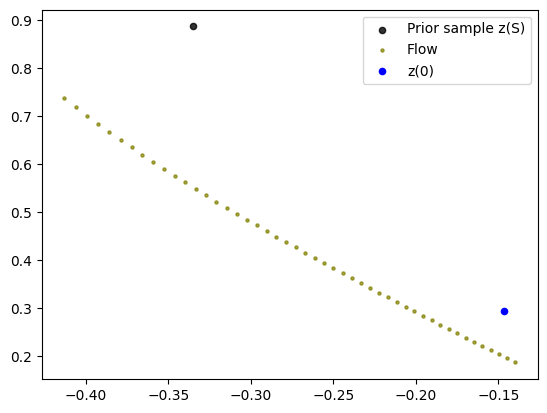

In [282]:
i = 763

# Plot the trajectories

start_x, start_y = df_times[0].iloc[i]['PC1'], df_times[0].iloc[i]['PC2']
end_x, end_y = df_times[end].iloc[i]['PC1'], df_times[end].iloc[i]['PC2']

plt.scatter(start_x, start_y, s=20, alpha=0.8, c='black')
plt.scatter(trajectory[:, i, 0], trajectory[:, i, 1], s=5, alpha=0.7, c='olive')
plt.scatter(end_x, end_y, s=20, alpha=1, c='blue')
plt.legend(['Prior sample z(S)', 'Flow', 'z(0)'])

plt.savefig('good_example_topcat.png')

Here is a sample where the trajectory was not so good...

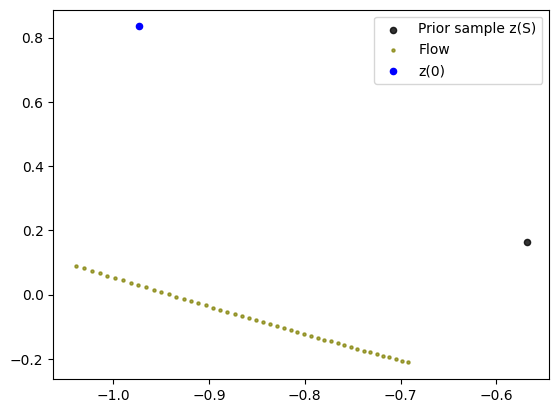

In [283]:
i = 724

start_x, start_y = df_times[0].iloc[i]['PC1'], df_times[0].iloc[i]['PC2']
end_x, end_y = df_times[end].iloc[i]['PC1'], df_times[end].iloc[i]['PC2']

plt.scatter(start_x, start_y, s=20, alpha=0.8, c='black')
plt.scatter(trajectory[:, i, 0], trajectory[:, i, 1], s=5, alpha=0.7, c='olive')
plt.scatter(end_x, end_y, s=20, alpha=1, c='blue')
plt.legend(['Prior sample z(S)', 'Flow', 'z(0)'])

plt.savefig('bad_example_topcat.png')

Here we create the vector field.

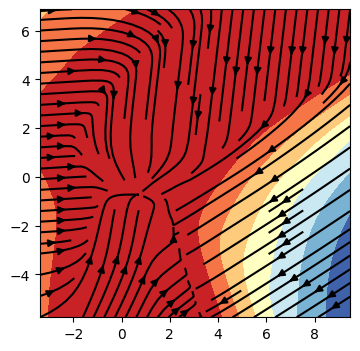

In [281]:
# Define the vector field over a space using a contour

n_pts = 50

x = torch.linspace(trajectory[:, :, 0].min(), trajectory[:, :, 0].max(), n_pts)
y = torch.linspace(trajectory[:, :, 1].min(), trajectory[:, :, 1].max(), n_pts)

X, Y = torch.meshgrid(x, y)
z = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], 1)
f = model.vf(0,z).cpu().detach()
fx, fy = f[:,0], f[:,1]
fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
ax.contourf(X.T, Y.T, torch.sqrt(fx.T ** 2 + fy.T ** 2), cmap='RdYlBu')

plt.savefig('vector_field_topcat.png')

Compute the mean squared error of the model.

In [382]:
from sklearn.metrics import mean_squared_error

times = []
mse = []

# Here we compute the MSE for each time interval

for i in sorted(df_times.keys())[1:]:
    tmp = df_times[0]
    tmp = tmp.loc[tmp['ID'].isin(df_times[i].ID.unique())]

    tmp2 = df_times[i]
    tmp2 = tmp2.loc[tmp2['ID'].isin(tmp['ID'])]

    tmp['PC1'] = pd.to_numeric(tmp['PC1'])
    tmp['PC2'] = pd.to_numeric(tmp['PC2'])

    tmp2['PC1'] = pd.to_numeric(tmp2['PC1'])
    tmp2['PC2'] = pd.to_numeric(tmp2['PC2'])

    tmp = tmp[["PC1", "PC2"]]
    tmp2 = tmp2[["PC1", "PC2"]]

    t_span = torch.linspace(0, i, steps=i)
    t_eval, trajectory = model(torch.Tensor(tmp.to_numpy()), t_span)
    trajectory = trajectory.detach().cpu()

    y_pred = trajectory[-1,:,:]
    print(i)
    times.append(i)
    mse.append(mean_squared_error(tmp2, y_pred))

4
8
16
32
48
72
96
120
144
168
192
216
240
264
288


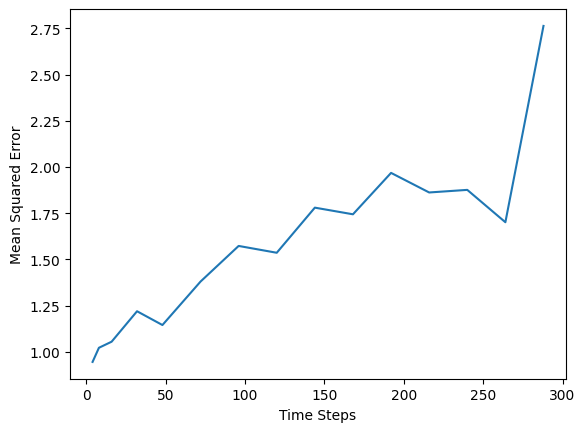

In [383]:
plt.plot(times, mse)
plt.xlabel('Time Steps')
plt.ylabel('Mean Squared Error')
plt.savefig('loss_over_time.png')

## 6. Predicting Censored Patient Data

First, we find a patient that was only there for the baseline and extract their principal components.

In [293]:
t016.loc[t016['ID'] == 184959]

,ID,VISIT,LABS_YN,labs_dt1,LABS_DOSE,NA_mmolL,K_mmolL,CL_mmolL,CO2_mmolL,BUN_mgdL,CR_mgdL,CHNG_DOSE,VER_ID
4123,184959.0,b'BASE',1.0,0.019165,0.0,139.0,3.3,98.0,29.0,13.0,1.3,0.0,b'A'


In [301]:
missing_patient = new_df.loc[new_df['ID'] == 184959][["PC1", "PC2"]]
missing_patient['PC1'] = pd.to_numeric(missing_patient['PC1'])
missing_patient['PC2'] = pd.to_numeric(missing_patient['PC2'])
missing_patient

,PC1,PC2
1392,-1.237429,-1.45727


Now we run our model on their data.

In [302]:
missing_patient = torch.Tensor(missing_patient.to_numpy()).to(device)
t_span = torch.linspace(0, 96, steps=96)

t_eval, trajectory = model(missing_patient, t_span)

In [312]:
# Get the patient data at the 12th week
n_dim = pca.inverse_transform(trajectory[11, 0, :].detach().numpy())
patient_data = scaler.inverse_transform(n_dim.reshape(-1, 1).T)

In [313]:
# Predicted data at time = 12 week
patient_data

array([[138.28206877,   4.02563853,  99.24407258,  29.70990014,
         19.65644806,   1.02678051]])

In [314]:
# Real data at baseline
t016.loc[t016['ID'] == 184959][measurements]

,NA_mmolL,K_mmolL,CL_mmolL,CO2_mmolL,BUN_mgdL,CR_mgdL
4123,139.0,3.3,98.0,29.0,13.0,1.3


Seems pretty reasonable!